#### This work is in colloboration with Zeshun Zong, Zunda Xu and Fiona. Refering to Rebekah

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pprint as pprint
import scipy.stats as sts
import warnings
warnings.filterwarnings('ignore')

In [2]:

files = ['AAPL', 'C', 'GBX', 'SPY', 'THO']
file_objs = []
for file in files:
    with open(file, 'rb') as pickle_file:
        file_objs.append(pickle.load(pickle_file))

# Problem 1

In [7]:
class OrderBook:
    """
    This class is defined to represent a single orderbook. 
    
    Attributes:
        data : raw data
        time : time (in seconds since midnight) of observations
        P : vector of prices
        Q : vector of quantities
        midpoint : actual midpoint of the BBO
        gamma : intercept of linear regression
        beta : slope of linear regression
        price : market clearing price
        ratio : noise signal ratio     
    """
    
    def __init__(self, data, window):
        
        self.data = data[1]
        self.timestamp = data[0]
        self.lower = window[0]
        self.upper = window[1]
        df = pd.DataFrame.from_dict(self.data, orient='index')
    
        df.columns = ['Quantity', 'Type', 'NaN0','NaN1']
        df = df[['Quantity', 'Type']]
        
        self.demand = df[df['Type'] == 'B'].sort_index(ascending=False)
        self.supply = df[df['Type'] == 'S'].sort_index()
        self.demand['QD'] = -self.demand['Quantity'].cumsum()
        self.supply['QS'] = self.supply['Quantity'].cumsum()
        
        orders = pd.concat([self.demand, self.supply])
        orders = orders.fillna(0)
        orders['Q'] = orders['QD'] + orders['QS']
        self.midpoint = orders[orders.Q < 0].index.values[0]
        
        self.orders = orders[(orders.index > window[0] * self.midpoint) 
                             & (orders.index < window[1]* self.midpoint)]
        
        self.Q = self.orders['Q']
        self.P = self.orders.index.values
                
    def est(self):
        slope, intercept, r_value, p_value, std_err = sts.linregress(self.P, self.Q)
        self.gamma = intercept
        self.beta = slope
        self.price = - self.gamma/self.beta
        self.ratio = self.beta    

    def plot(self, name):
        fig = plt.figure(figsize=(10,7))
        plt.plot(self.demand.index.values, self.demand['QD'], label='demand')
        plt.plot(self.supply.index.values, self.supply['QS'], label='supply')
        p_grid = np.linspace(self.lower * self.midpoint, self.upper * self.midpoint)
        plt.plot(p_grid, self.gamma + self.beta * p_grid, 'k', label='Estimated Equation')
        plt.xlim(0.5 * self.midpoint, 1.5 * self.midpoint)
        plt.xlabel('Price')
        plt.ylabel('Quantity')
        plt.title(name + ' Stock at t = %i' %self.timestamp)
        plt.legend()
        plt.show()
        
    def compare(self):
        print("The estimated market clearing price is: %f" %self.price)
        print("The actual midpoint of the BBO is: %f" %self.midpoint)

In [8]:
def show(file, t, name):
    test = OrderBook(file[t], (0.9, 1.1))
    test.est()
    test.plot(name)
    test.compare()

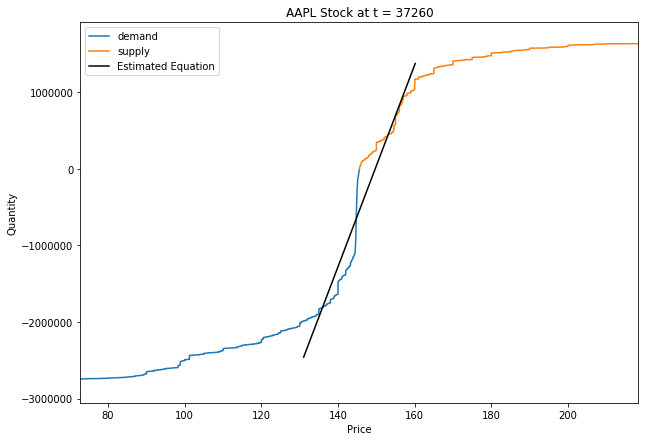

The estimated market clearing price is: 149.686787
The actual midpoint of the BBO is: 145.580000


In [9]:
show(file_objs[0], 50, 'AAPL')

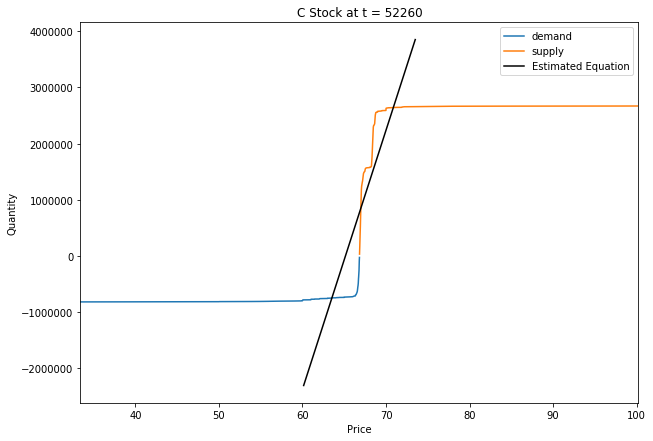

The estimated market clearing price is: 65.141571
The actual midpoint of the BBO is: 66.820000


In [10]:
show(file_objs[1], 300, 'C')

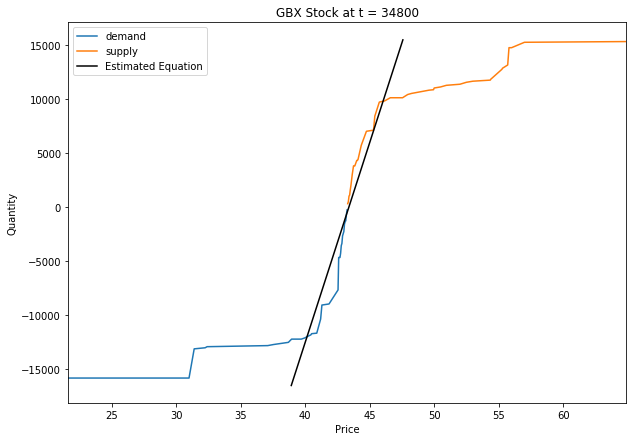

The estimated market clearing price is: 43.393255
The actual midpoint of the BBO is: 43.250000


In [11]:
show(file_objs[2], 9, 'GBX')

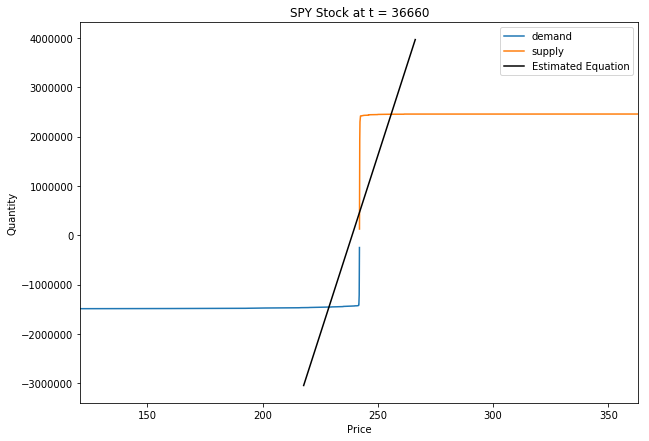

The estimated market clearing price is: 238.868532
The actual midpoint of the BBO is: 242.040000


In [12]:
show(file_objs[3], 40, 'SPY')

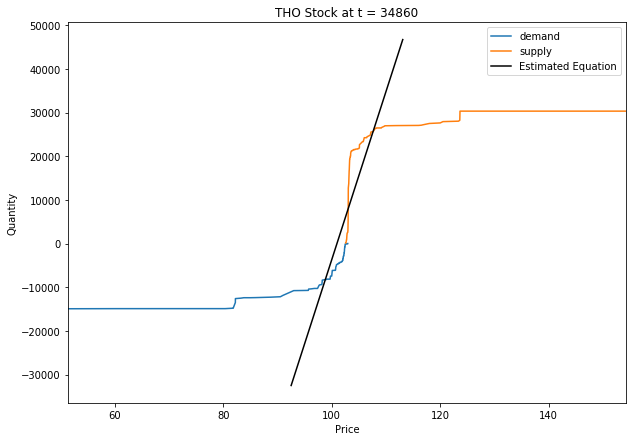

The estimated market clearing price is: 100.966398
The actual midpoint of the BBO is: 102.810000


In [13]:
show(file_objs[4], 10, 'THO')

# Problem 2

In [14]:
def plot_ratio(file_obj, title):
    ratio = np.zeros(len(file_obj), dtype=np.float64)
    for i in range(len(file_obj)):
        book = OrderBook(file_obj[i], (0.9, 1.1))
        book.est()
        ratio[i] = book.ratio
    
    fig = plt.figure(figsize=(10,7))
    plt.plot(ratio)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel(r'$\frac{2\sigma_{u}}{\sqrt{\Sigma_{0}}$')
    plt.show()

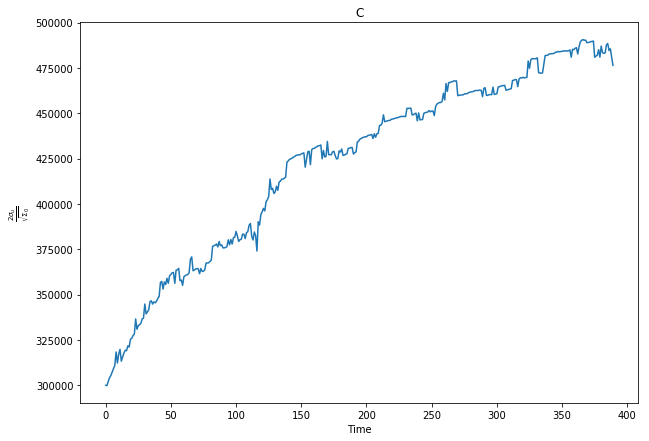

In [36]:
plot_ratio(file_objs[1], 'C')

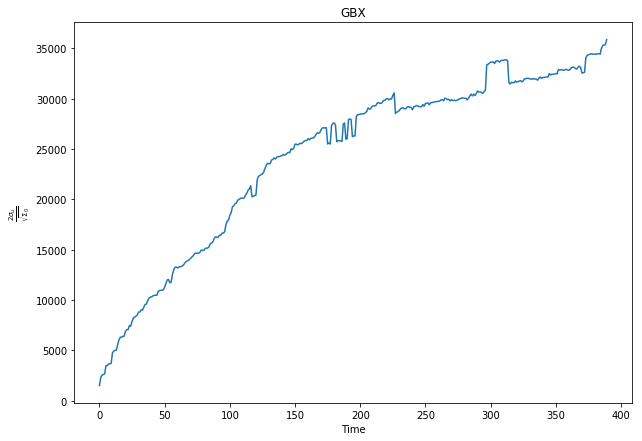

In [37]:
plot_ratio(file_objs[2], 'GBX')

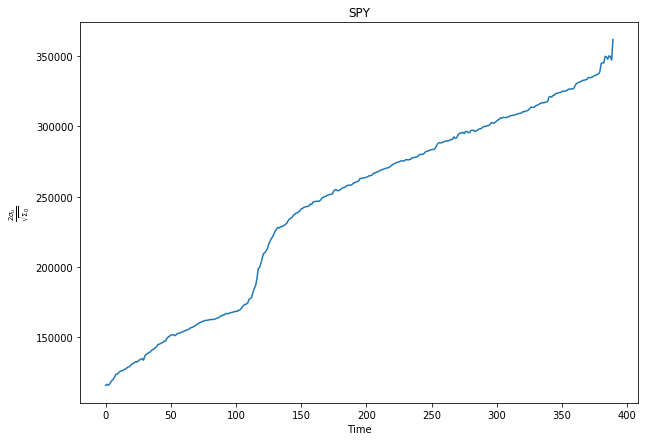

In [38]:
plot_ratio(file_objs[3], 'SPY')

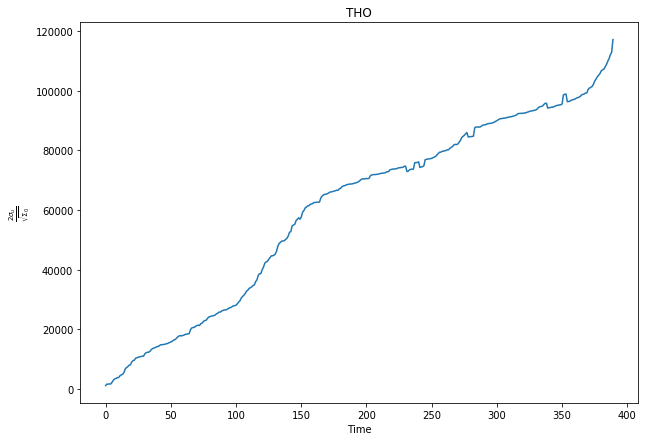

In [39]:
plot_ratio(file_objs[4], 'THO')

# Problem 3

In [43]:
def compare_p0(file_obj,title, cutval=1):
    p_est = np.zeros(len(file_obj), dtype=np.float64)
    p_act = np.zeros(len(file_obj), dtype=np.float64)
    for i in range(len(file_obj)):
        book = OrderBook(file_obj[i], (0.9, 1.1))
        book.est()
        p_est[i] = book.price
        p_act[i] = book.midpoint

    fig = plt.figure(figsize=(8,5))
    plt.plot(p_est - p_act, label=r'$\hat{p}_0 - p_0$')
    plt.title(title)
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel(r'Difference')
    plt.show()


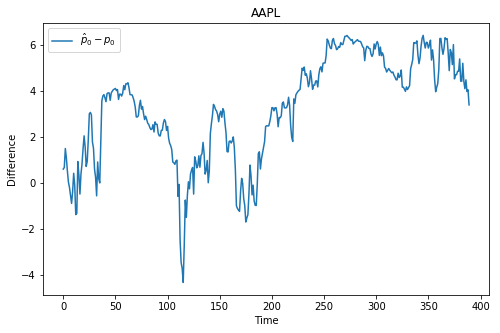

In [44]:
compare_p0(file_objs[0], 'AAPL')

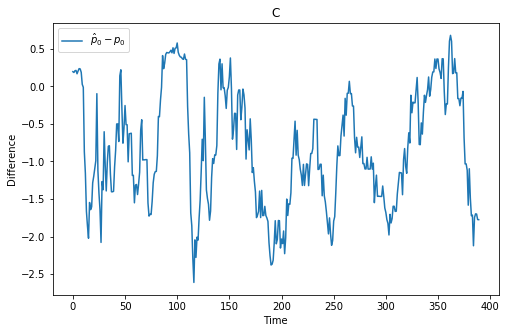

In [46]:
compare_p0(file_objs[1], 'C')

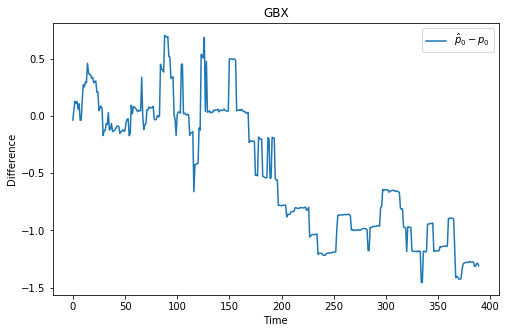

In [47]:
compare_p0(file_objs[2], 'GBX')

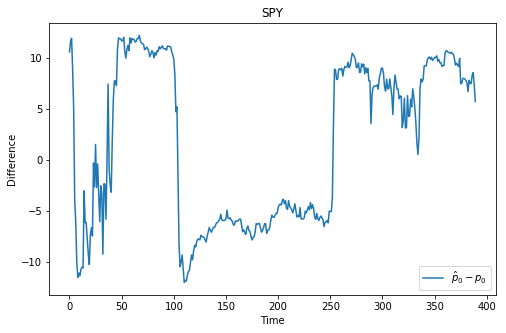

In [48]:
compare_p0(file_objs[3], 'SPY')

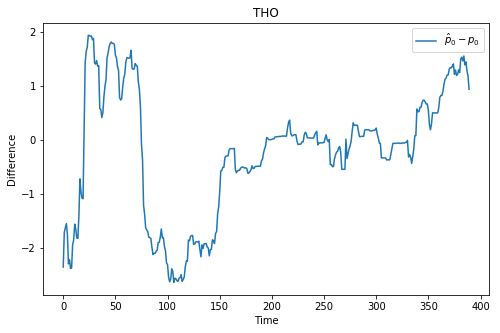

In [49]:
compare_p0(file_objs[4], 'THO')

From the graphs shown above, in general, the estimates value follow overall trends of the actual midpoints, but it's also sensitive and not that stabel all that time.